In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import repeat
from extra_packages.OutputInterface import OutputInterface
import extra_packages.sperhical_expansion as se
import SFALinearPulse as SFA_Lin
from matplotlib.colors import LogNorm
from scipy.special import sph_harm

In [2]:
import multiprocessing
#import ipyparallel as ipp
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default
pool = multiprocessing.Pool(processes=cpus)

In [3]:
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2

### Let's try to expand the chiral hydrogen state...

In [4]:
def hyd_4d(r, theta, phi, m):
    R_42 = 1/(64*np.sqrt(5)) * (1 - r/12) * r**2 * np.exp(-r/4)
    return R_42 * sph_harm(m, 2, phi, theta)

def hyd_4f(r, theta, phi, m):
    R_43 = 1/(768*np.sqrt(35)) * r**3 * np.exp(-r/4)
    return R_43 * sph_harm(m, 3, phi, theta)

def hyd_rho(r, theta, phi, pm=1):
    return 0.5 * (hyd_4d(r, theta, phi, pm) + 1j*hyd_4f(r, theta, phi, pm) - hyd_4d(r, theta, phi, -pm) + 1j*hyd_4f(r, theta, phi, -pm))

rho_p = lambda r, theta, phi : hyd_rho(r, theta, phi, 1)
rho_m = lambda r, theta, phi : hyd_rho(r, theta, phi, -1)

Ip = 1/(2*4**2)
kappa = np.sqrt(2 * Ip)

In [5]:
n_r = 50
r_lst = np.linspace(1, 50, n_r)
flms = []
for i, r in enumerate(r_lst):
    print(f'Evaluating at r={r:.4f} \t Nr. {i+1}/{n_r}')
    flms.append(se.spherical_expansion(lambda theta, phi: rho_p(r, theta, phi), 50))

Evaluating at r=1.0000 	 Nr. 1/50
Evaluating at r=2.0000 	 Nr. 2/50
Evaluating at r=3.0000 	 Nr. 3/50
Evaluating at r=4.0000 	 Nr. 4/50
Evaluating at r=5.0000 	 Nr. 5/50
Evaluating at r=6.0000 	 Nr. 6/50
Evaluating at r=7.0000 	 Nr. 7/50
Evaluating at r=8.0000 	 Nr. 8/50
Evaluating at r=9.0000 	 Nr. 9/50
Evaluating at r=10.0000 	 Nr. 10/50
Evaluating at r=11.0000 	 Nr. 11/50
Evaluating at r=12.0000 	 Nr. 12/50
Evaluating at r=13.0000 	 Nr. 13/50
Evaluating at r=14.0000 	 Nr. 14/50
Evaluating at r=15.0000 	 Nr. 15/50
Evaluating at r=16.0000 	 Nr. 16/50
Evaluating at r=17.0000 	 Nr. 17/50
Evaluating at r=18.0000 	 Nr. 18/50
Evaluating at r=19.0000 	 Nr. 19/50
Evaluating at r=20.0000 	 Nr. 20/50
Evaluating at r=21.0000 	 Nr. 21/50
Evaluating at r=22.0000 	 Nr. 22/50
Evaluating at r=23.0000 	 Nr. 23/50
Evaluating at r=24.0000 	 Nr. 24/50
Evaluating at r=25.0000 	 Nr. 25/50
Evaluating at r=26.0000 	 Nr. 26/50
Evaluating at r=27.0000 	 Nr. 27/50
Evaluating at r=28.0000 	 Nr. 28/50
Evaluating

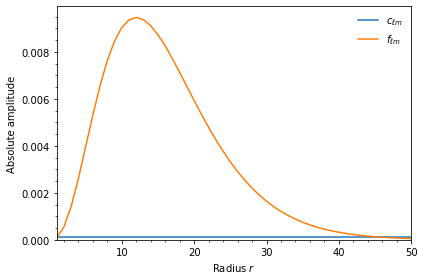

In [6]:
plt.figure(facecolor='white')

def radial(r, kappa):
    return r**(1/kappa - 1) * np.exp(-kappa*r)

sgn, l, m = 1,3,1
#plt.plot(r_lst, np.array([output.eval_orbital_spherical(r, np.pi/2, 0) for r in r_lst])*100, label=r'$\psi_0$')
plt.plot(r_lst, np.abs(np.array(flms)[:, sgn, l, m])/radial(r_lst, kappa), label=r'$c_{\ell m}$')
plt.plot(r_lst, np.abs(np.array(flms)[:, sgn, l, m]),  label=r'$f_{\ell m}$')
plt.legend(frameon=False)
plt.xlabel(r'Radius $r$')
plt.ylabel(r'Absolute amplitude')
plt.minorticks_on()
plt.xlim(r_lst[0], r_lst[-1])
plt.ylim(bottom=0)
plt.tight_layout()

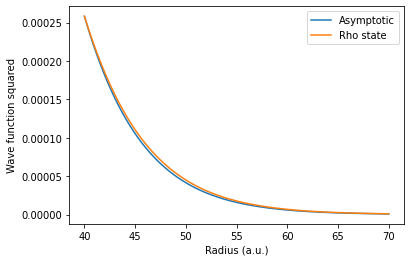

In [7]:
clm_array = se.get_as_coeffs(rho_p, 40, 50, Ip, abs_thresh=1e-8)
r_list = np.linspace(40, 70, 100)

phi = 0
theta = 0.3#np.pi/2

plt.figure(facecolor='white')
plt.plot(r_list, np.abs(se.eval_asymptotic(r_list, theta, phi, clm_array, Ip)), label='Asymptotic')
plt.plot(r_list, np.abs(rho_p(r_list, theta, phi)), label='Rho state')

plt.legend()
plt.xlabel('Radius (a.u.)')
plt.ylabel('Wave function squared')
plt.show()

In [8]:
SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")

N = 50
pzList = np.linspace(-1.7, 1.7, 2*N)
pxList = np.linspace(0, 1.7, N)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.

M_grid = np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array))))

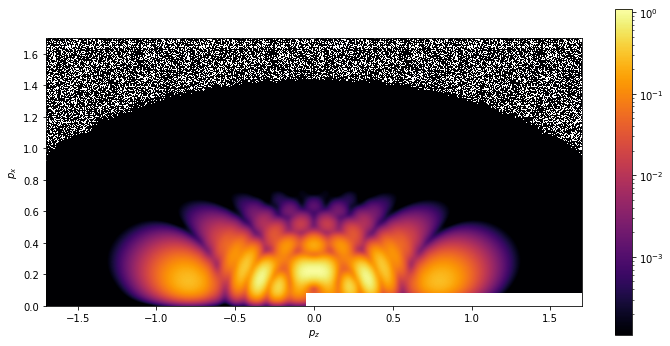

In [9]:
plt.figure(facecolor='white', figsize=(12,6))

M2_grid = np.abs(M_grid)**2
MMax = np.max(M2_grid)

plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
           cmap='inferno', norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic', aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()

### OAM time!

In [10]:
N = 50
pzList = np.linspace(-1.7, 1.7, 2*N)
pxList = np.linspace(0, 1.5, N)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.

clm_array_p = se.get_as_coeffs(rho_p, 40, 30, Ip, abs_thresh=1e-6)
clm_array_m = se.get_as_coeffs(rho_m, 40, 30, Ip, abs_thresh=1e-6)

In [11]:
OAM_list = [-1,1]
OAM_grids = []
rho_grids = []

for i in [1,-1]:
    OAM_grids = []

    for OAM in OAM_list:
        print(f'Calculating for OAM : {OAM}')
        SP.OAM = int(OAM)
        if i == 1:
            OAM_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_p)))))
        else:
            OAM_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_m)))))
    rho_grids.append(OAM_grids[:])

Calculating for OAM : -1
Calculating for OAM : 1
Calculating for OAM : -1
Calculating for OAM : 1


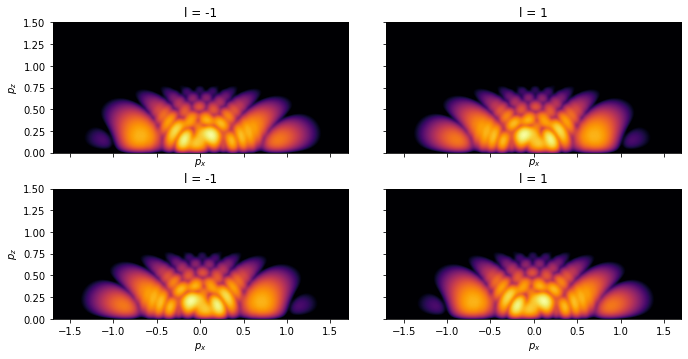

In [12]:
fig, axs = plt.subplots(2, 2, sharey=True, sharex = True, figsize=(10,5), facecolor='white')
plt.tight_layout()
for j, OAM_grids in enumerate(rho_grids):
    for i, Ml_grid in enumerate(OAM_grids):
        Ml2_grid = np.abs(Ml_grid)**2
        Ml_max = np.max(Ml2_grid)
        filter_list = Ml2_grid > np.max(Ml2_grid * 1e-8)
        Ml2_grid[np.logical_not(filter_list)] = 1e-8

        axs[j, i].imshow(np.flip(Ml2_grid,0), cmap='inferno', aspect=1, interpolation = 'bicubic', norm=LogNorm(vmin=Ml_max*1e-4, vmax=Ml_max),
                      extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)))
        axs[j, i].set_title(f'l = {OAM_list[i]}')
        axs[j, i].set_xlabel('$p_x$')

    axs[0,0].set_ylabel('$p_z$')
    axs[1,0].set_ylabel('$p_z$')

plt.tight_layout()

### Looks like it should - -1 for plus is the same as 1 for minus (and the other way around)!

### Now we can calculate the PEVD - do it for just plus state, cause we want high-res!

In [13]:
OAM_list = [-1, 1]

PEVD_grids = []

N = 100
pzList = np.linspace(-1.5, 1.5, 2*N)
pxList = np.linspace(0, 1.4, N)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.

for OAM in OAM_list:
    print(f'Calculating for OAM : {OAM}')
    SP.OAM = int(OAM)
    PEVD_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_p)))))

Calculating for OAM : -1
Calculating for OAM : 1


In [14]:
OAM_m, OAM_p = PEVD_grids
OAM2_m = np.abs(OAM_m)**2
OAM2_p = np.abs(OAM_p)**2

PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))
PEVD = np.nan_to_num(PEVD, nan=0)

filter_list1 = OAM2_m > np.max(OAM2_m*1e-4)
filter_list2 = OAM2_p > np.max(OAM2_p*1e-4)
combined_filter = np.logical_or(filter_list1, filter_list2)
PEVD[np.logical_not(combined_filter)] = 0
#PEVD[np.logical_not(filter_list1)] = 0
#plt.imshow(np.flip(diff_grid.T), cmap='seismic', interpolation='bicubic')

/tmp/ipykernel_20150/3026794779.py:5: RuntimeWarning: invalid value encountered in true_divide
  PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))


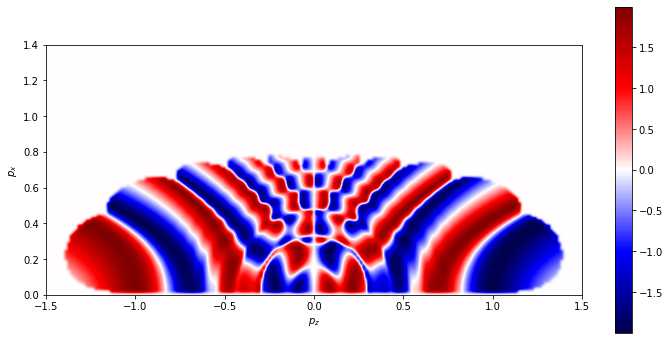

In [15]:
plt.figure(facecolor='white', figsize=(12,6))

plt.imshow(np.flip(PEVD,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
           cmap='seismic', #norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic')#, aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()